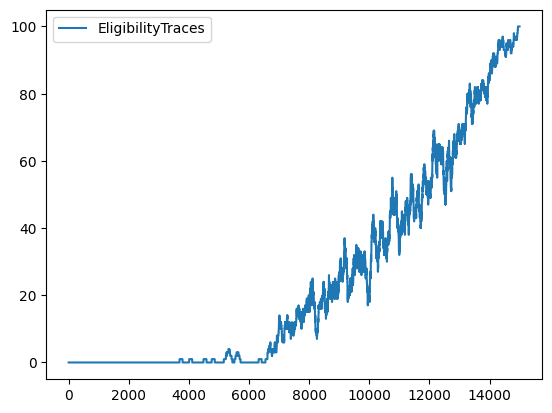

In [37]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from gym.envs.toy_text.frozen_lake import generate_random_map

def EligibilityTraces(episodes, env_seed):

    env = gym.make("FrozenLake-v1", desc=env_seed, map_name="12x12", is_slippery=False, render_mode=None)

    q = np.zeros((env.observation_space.n, env.action_space.n)) # init a 64 x 4 array
    eligibility_traces = np.zeros((env.observation_space.n, env.action_space.n))  # Initialize eligibility traces

    learning_rate_a = 0.9 # alpha or learning rate
    discount_factor_g = 0.25 # gamma or discount rate. Near 0: more weight/reward placed on immediate state. Near 1: more on future state.
    epsilon = 1         # 1 = 100% random actions
    epsilon_decay_rate = 1/episodes   # epsilon decay rate. 1/0.0001 = 10,000
    rng = np.random.default_rng()   # random number generator

    rewards_per_episode = np.zeros(episodes)

    for i in range(episodes):
        state = env.reset()[0]  # states: 0 to 63, 0=top left corner,63=bottom right corner
        terminated = False      # True when fall in hole or reached goal
        truncated = False       # True when actions > 200

        while(not terminated and not truncated):
            if rng.random() < epsilon:
                action = env.action_space.sample() # actions: 0=left,1=down,2=right,3=up
            else:
                action = np.argmax(q[state,:])

            new_state,reward,terminated,truncated,_ = env.step(action)
            if reward == 1:
                reward = 0
            elif terminated:
                reward = -99
            else:
                reward = -1

            # Update eligibility traces
            eligibility_traces *= discount_factor_g  # Decay traces
            eligibility_traces[state, action] += 1  # Increment trace for visited state-action pair

            # Q-learning update with eligibility traces
            delta = reward + discount_factor_g * np.max(q[new_state, :]) - q[state, action]
            q += learning_rate_a * delta * eligibility_traces

            state = new_state

        epsilon = max(epsilon - epsilon_decay_rate, 0)

        if(epsilon==0):
            learning_rate_a = 1/episodes

        if reward == 0:
            rewards_per_episode[i] = 1
    env.close()

    sum_rewards = np.zeros(episodes)
    for t in range(episodes):
        sum_rewards[t] = np.sum(rewards_per_episode[max(0, t-100):(t+1)])

    plt.plot(sum_rewards, label="EligibilityTraces")
    plt.legend()

    plt.savefig('images/frozen_lake_EligibilityTraces.png')
    return q


env_seed = generate_random_map(size=12)
EligibilityTraces_model = EligibilityTraces(15000, env_seed)


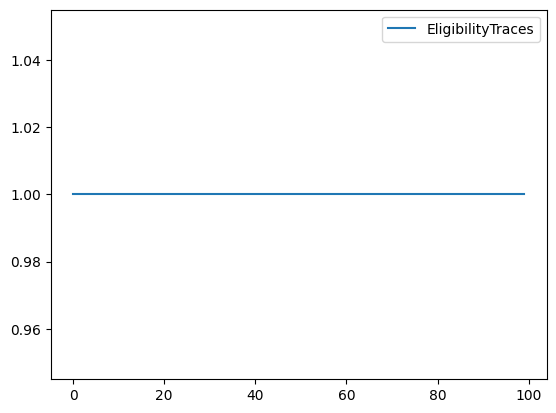

In [38]:
# EligibilityTraces_model = EligibilityTraces(100000, env_seed)
# EligibilityTraces_model1 = EligibilityTraces(50000, env_seed)
import FrozenLakeFunctions as flf

flf.testModel(EligibilityTraces_model, "EligibilityTraces", env_seed, 100)
flf.seeModel(EligibilityTraces_model, env_seed)